# Robustness and the effects of local renormalization

Yixin's ICML model with one datapoint is,
\begin{align*}
f(x, w, \theta) &= p(x \mid \theta)^w \, p(w) \, p(\theta),
\end{align*}
where $p(x \mid \theta)$ is a likelihood (a normalized density on $x$) and $p(w)$ and $p(\theta)$ are normalized prior distributions.

Now we think of $f(x, w, \theta)$ as an unnormalized joint distribution.  The normalized version is,
\begin{align*}
p(x, w, \theta) &=\frac{ f(x, w, \theta)}{Z} \\
Z &= \int f(x', w', \theta') \, \mathrm{d} x' \, \mathrm{d}w' \, \mathrm{d}\theta'.
\end{align*}
I'm using primes to denote the variables of integration.  I know this looks a bit hideous, but the primes will help avoid confusion below.

The goal is to estimate the posterior,
\begin{align*}
p_f(w, \theta \mid x) &= \frac{p(x, w, \theta)}{p(x)} \\
&= \frac{ f(x, w, \theta)}{Z \int \frac{f(x, w', \theta')}{Z} \, \mathrm{d}w' \, \mathrm{d} \theta'}   \\
&= \frac{ f(x, w, \theta)}{\int f(x, w', \theta') \, \mathrm{d}w' \, \mathrm{d} \theta'}.
\end{align*}

# Why does this raise eyebrows?

The concern with this approach is that raising the likelihood to a power does not result in a properly normalized likelihood.  That is, $p(x \mid \theta)^w$ does not integrate to one.  This doesn't mean that the objective is invalid -- we can still view $f(x, w, \theta)$ as an unnormalized joint and perform posterior inference -- but it could have some weird and unintuitive effects.  

To first order, raising to a power does what we want: as $w$ goes to zero, the likelihood becomes more an more uniform; as $w$ goes to one, the likelihood approaches the original likelihood.  The issue is that unless you renormalize, the likelihood terms are not normalized measures on $x$, and the terms in the likelihood for different datapoints (i.e. $x_n$, not shown above) will not be directly comparable. In log space, you would effectively be summing terms with different units.  

As a prelude to the example below, here's what happens when you raise a standard normal density to a power with and without renormalization.

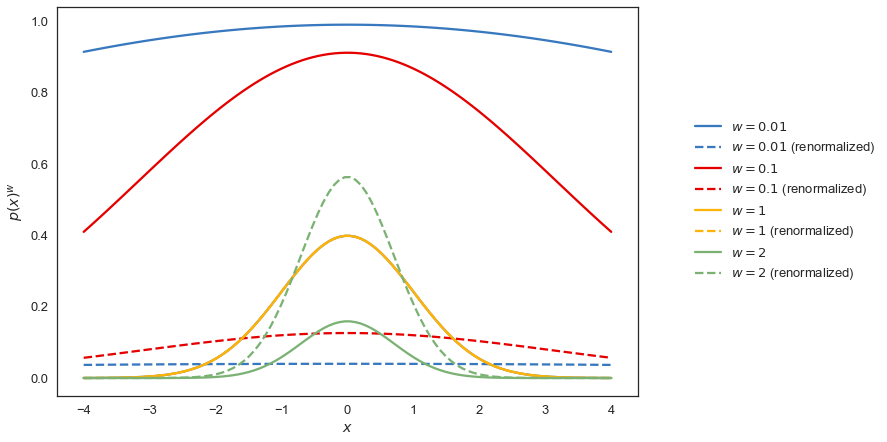

In [1]:
import numpy as np
from scipy.misc import logsumexp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")
color_names = ["windows blue",
               "red",
               "amber",
               "faded green"]
colors = sns.xkcd_palette(color_names)
sns.set_palette(colors)

def lp_gaussian(x, m, s): 
    return -0.5 * np.log(2 * np.pi) - 0.5 * np.log(s) - 0.5 / s * (x - m)**2

xx = np.linspace(-4, 4, 100)
plt.plot(xx, np.exp(lp_gaussian(xx, 0, 1)))

for i,w in enumerate([0.01, 0.1, 1, 2]):
    plt.plot(xx, np.exp(w * lp_gaussian(xx, 0, 1)), 
             ls='-', color=colors[i], 
             label="$w={}$".format(w))
    plt.plot(xx, np.exp(lp_gaussian(xx, 0, 1/w)), 
             ls='--', color=colors[i], 
             label="$w={}$ (renormalized)".format(w))

plt.legend(loc="center right", bbox_to_anchor=(1.33, 0.25, 0.1, 0.5))
plt.xlabel("$x$")
plt.ylabel("$p(x)^w$")

If the goal is to find assignments of $w$ and $\theta$ that have high values of $f$, then driving the weight to zero trivially achieves this.

# Renormalization 
The question we asked on the whiteboard was, **does the posterior of $w$ and $\theta$ change if you normalize the likelihoods in $f$?** Specifically, if we replace $f$ with,
\begin{align*}
g(x, w, \theta) &= \frac{p(x \mid \theta)^w}{Z(w, \theta)} \, p(w) \, p(\theta), \\
Z(w, \theta) &= \int p(x' \mid \theta)^w \, \mathrm{d} x',
\end{align*}
does the posterior change?  The answer is pretty clearly yes, it must change because we've added another term to the unnormalized joint distribution that effectively penalizes small weights.  How does the posterior change precisely though?

Following the same logic as above, the new posterior is,
\begin{align*}
p_g(w, \theta \mid x) 
&= \frac{ g(x, w, \theta)}{\int g(x, w', \theta') \, \mathrm{d}w' \, \mathrm{d} \theta'} \\
&= \frac{p(x \mid \theta)^w p(w) \, p(\theta)}{Z(w, \theta) \int \frac{p(x \mid \theta)^{w'}}{Z(w', \theta')} p(w') \, p(\theta') \, \mathrm{d} w' \, \mathrm{d} \theta'} \\
&= \frac{f(x, w, \theta)}{\int \frac{Z(w, \theta)}{Z(w', \theta')} \, f(x, w', \theta') \, \mathrm{d} w' \, \mathrm{d} \theta'}.
\end{align*}

We see that the two expressions are very similar, but the denominator is a weighted integral of $f$, where the weights are the ratio $Z(w, \theta) / Z(w', \theta')$.  If raising to the power $w$ somehow didn't change the normalization of the likelihood much, then the two posteriors would be similar. But it seems likely that they will differ substantially when $w$ and $w'$ are not close. 

# A simple example

Start with a simple model:
\begin{align*}
p(x \mid \theta) &= \mathcal{N}(0, \theta^{-1}), \\
p(w) &= \mathrm{Gamma}(\frac{\nu}{2}, \frac{\nu}{2}), \\
p(\theta) &= \mathrm{Gamma}(\alpha, \beta).
\end{align*}
where $\theta$ is the precision (the natural parameter) of a Gaussian likelihood.

In the original model,
\begin{align*}
\log p_f(w, \theta \mid x) &= w \log p(x \mid \theta) + \log p(w; \nu) + \log p(\theta ; \alpha, \beta) + c, \\
&= +\frac{w}{2} \log \theta - \frac{1}{2} w \theta x^2 + \left(\frac{\nu}{2} - 1 \right) \log w - \frac{\nu w}{2} + (\alpha - 1) \log \theta - \beta \theta + c.
\end{align*}
where $c$ is constant with respect to $w$ and $\theta$. 

In the renormalized model, we can compute $Z(w, \theta)$ exactly. Raising the Gaussian density to a power simply scales its natural parameters by $w$; this has the effect of multiplying the precision by $w$.  Here the mean is zero anyway, but this rescaling would leave the mean unchanged in all cases. In short,
\begin{align*}
\frac{p(x \mid \theta)^w}{Z(w, \theta)} = \mathcal{N}\left(x \; \bigg| \; 0, (w \theta)^{-1} \right),
\end{align*}
from which we deduce the renormalization function,
\begin{align*}
Z(w, \theta) = \frac{\left(\frac{2 \pi}{w \theta} \right)^{-1/2}}{(\frac{2 \pi}{\theta})^{-w/2}} 
= (2 \pi)^{(w-1)/2} w^{1/2} \theta^{-(w-1)/2}
\end{align*}

This yields,
\begin{align*}
g(x, w, \theta) &= 
\mathcal{N} \left(x \mid 0,  (w \theta)^{-1} \right) \, 
\mathrm{Gamma} \left(w \mid \frac{\nu}{2}, \frac{\nu}{2} \right) \, 
\mathrm{Gamma} \left(\theta \mid \alpha, \beta \right).
\end{align*}
Marginalizing out the weights $w$ yields a Student's t likelihood,
\begin{align*}
g(x, \theta) &= \mathrm{t}(x \mid 0, \theta^{-1}, \nu) \, \mathrm{Gamma}(\theta \mid \alpha, \beta),
\end{align*}
which is commonly used for robust Bayesian inference.  This expression makes it seem like we could equally well have integrated out $\theta$ to obtain a robust model, but remember that when we typically have weights $w_n$ for each of $N$ datapoints, and only a single variance parameter $\theta$.



# Plot it

In [2]:
# Fix some hyperparameters
alpha = 2
beta = 2
nu = 4

def lp_gamma(x, a, b): 
    return (a - 1) * np.log(x) - beta * x

def lp_prior(w, theta): 
    return lp_gamma(w, nu/2.0, nu/2.0) + lp_gamma(theta, alpha, beta)

def lp_f(x, w, theta): 
    return w * lp_gaussian(x, 0, 1./ theta) + lp_prior(w, theta)

def lp_g(x, w, theta): 
    return lp_gaussian(x, 0, 1./(theta * w)) + lp_prior(w, theta)

# Evaluate the posteriors on a grid
lim = 3
ww = np.linspace(1e-4, lim, 100)
th = np.linspace(1e-4, lim, 100)
W, T = np.meshgrid(ww, th)

def make_plot(x):
    Lp = lp_prior(W, T)
    Lp -= logsumexp(Lp)
    Lf = lp_f(x, W, T)
    Lf -= logsumexp(Lf)
    Lg = lp_g(x, W, T)
    Lg -= logsumexp(Lg)

    # Plot prior and posteriors p_f and p_g
    plt.figure(figsize=(9,3))
    plt.subplot(131, aspect="equal")
    plt.contour(W, T, np.exp(Lp))
    plt.xlabel("$w$")
    plt.ylabel("$\\theta$")
    plt.xticks(np.arange(lim+1))
    plt.yticks(np.arange(lim+1))
    plt.title("$p(w) \, p(\\theta)$")

    plt.subplot(132, aspect="equal")
    plt.contour(W, T, np.exp(Lf))
    plt.xlabel("$w$")
    plt.ylabel("$\\theta$")
    plt.xticks(np.arange(lim+1))
    plt.yticks(np.arange(lim+1))
    plt.title("$p_f(w, \\theta \\mid x = {})$".format(x))

    plt.subplot(133, aspect="equal")
    plt.contour(W, T, np.exp(Lg))
    plt.xlabel("$w$")
    plt.ylabel("$\\theta$")
    plt.xticks(np.arange(lim+1))
    plt.yticks(np.arange(lim+1))
    plt.title("$p_g(w, \\theta \\mid x = {})$".format(x))
    
    plt.tight_layout(pad=0.1, rect=(0, 0, 1, 0.9))
    

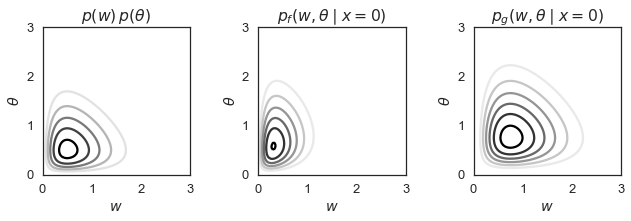

In [3]:
make_plot(0)

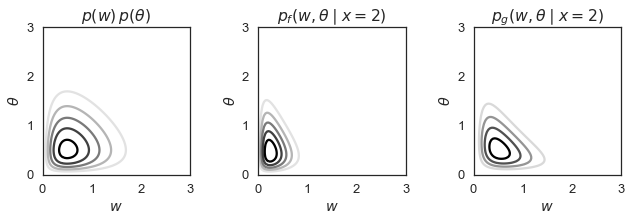

In [4]:
make_plot(2)

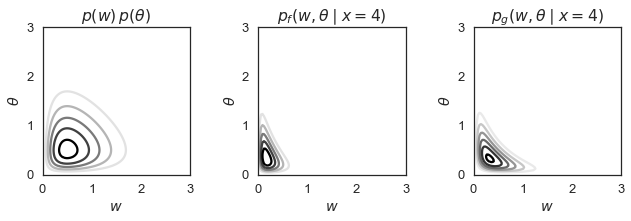

In [5]:
make_plot(4)

# Interpretation of these plots
I've plotted the weights $w$ vs the precision $\theta$ to emphasize their symmetry.  When there is a single datapoint, you can trade-off between a higher precision and a lower weight or vice versa; the renormalized likelihood only depends on their product.  The prior could break this symmetry, but here I've set both priors to be $\mathrm{Gamma}(2,2)$.   

This symmetry is apparent in the renormalized model's posterior $p_g$, but it is not present in $p_f$.  As expected, if you don't renormalize the likelihoods it looks like you overly penalize large weights.  In this example, it doesn't change the MAP estimate of $\theta$ much, but the difference is non-trivial in the first plot (where $x=0$, the mode of the likelihood). 

# Renormalization for exponential family likelihoods

Exponential family likelihoods are sometimes simple to renormalize. Let $\theta$ be the natural parameter of an exponential family model. We have,
\begin{align*}
\log p(x \mid \theta)^w = w \langle \theta, t(x) \rangle - w \log A(\theta) + w \log h(x),
\end{align*}
where $t(x)$ is a vector of sufficient statistics, $A(\cdot)$ is the partition function, and $h(x)$ is the base measure. Whether or not renormalization is easy depends on the base measure. Consider the two cases:
1. When the **base measure is independent of $x$**, as it is for the Gaussian, gamma, and some other distributions, we write $h(x) \equiv h$, such that
\begin{align*}
Z(w, \theta) &= \int p(x' \mid \theta)^w \, \mathrm{d} x' \\
             &= \frac{h^w}{h} \frac{A(w \theta)}{A(\theta)^w} \int h \exp \left \{ \langle w \theta, t(x') \rangle - \log A(w \theta) \right \} \, \mathrm{d} x'\\
             &= \frac{h^w}{h} \frac{A(w \theta)}{A(\theta)^w} \int p(x' \mid w \theta) \, \mathrm{d} x'\\
             &= \frac{h^w}{h} \frac{A(w \theta)}{A(\theta)^w}.
\end{align*}
In this case, raising the likelihood to a power does not change the family, it only scales the natural parameters. After renormalization,
\begin{align*}
\frac{p(x \mid \theta)^w}{Z(w, \theta)} &= p(x \mid w \theta),
\end{align*}
where $p$ is the same density on both sides of the equality. 

2. When the **base measure depends on $x$**, as for the Poisson distribution,
\begin{align*}
Z(w, \theta) &= \int p(x' \mid \theta)^w \, \mathrm{d} x' \\
             &= \frac{A(w \theta)}{A(\theta)^w} \int h(x')^w \exp \left \{ \langle w \theta, t(x') \rangle - \log A(w \theta) \right \} \, \mathrm{d} x'.
\end{align*}
This seems hard to solve in general form.  We can say that this renormalization yields another exponential family density with parameters $w \theta$, but with a different base measure, namely $h(x)^w$. 

Renormalization is easy in the first case, and this is particularly appealing for the Gaussian distribution. For general multivariate Gaussian distributions, the natural parameters, sufficient statistics, and partition function are,
\begin{align*}
\theta &= \begin{bmatrix} J \\ h \end{bmatrix} \\
t(x) &= \begin{bmatrix} -\frac{1}{2} xx^\mathsf{T} \\ x \end{bmatrix} \\
\log A(\theta) &= \frac{1}{2} h^\mathsf{T} J^{-1} h - \frac{1}{2} \log |J| + \frac{D}{2} \log 2 \pi.
\end{align*}
The mean parameters are obtained by $\mu = J^{-1} h$ and $\Sigma = J^{-1}$.  

As we said above, scaling $\theta$ by a constant does changes the precision but not the mean.  This lends the weights a particularly nice interpretation: large weights increase the precision; small weights shrink the precision.  When the weight goes to zero, the Gaussian approaches a degenerate uniform distribution.